In [54]:
import numpy as np

import torchaudio
import torch
import torch.nn.functional
import librosa
import matplotlib.pyplot as plt

In [58]:
def txt_to_tensor(input_file_path, sampling_rate=12800):
    # Read the data from the text file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    samples = []
    for line in lines:
        _, sample = line.split("\t")
        samples.append(float(sample))
    
    # Convert list to numpy array
    samples_array = np.array(samples, dtype=np.float32)
    
    # Convert numpy array to tensor
    tensor_data = torch.from_numpy(samples_array)
    
    return tensor_data


# Data Sample
input_file = 'sampledata/가속정상.txt'  # Adjust this to your text file path
tensor_data = txt_to_tensor(input_file)
# tensor_data = tensor_data.unsqueeze(0)
# tensor_data.shape

In [59]:
def perform_stft(waveform, n_fft=512, win_length=None, hop_length=None, window_fn=torch.hann_window):
    stft = torch.stft(waveform, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window_fn(n_fft), return_complex=True)
    return stft

stft_result = perform_stft(tensor_data)
# stft_result = torch.abs(stft_result)
stft_result.shape

torch.Size([257, 1463])

In [60]:
def apply_a_weighting_librosa(stft_result, sample_rate):
    # STFT 결과로부터 FFT 크기 추정
    n_fft = (stft_result.size(0) - 1) * 2
    
    # 주파수 bins 계산
    freqs = np.linspace(0, sample_rate / 2, stft_result.size(0))
    
    # A-weighting dB 값 계산
    a_weighting_db = librosa.A_weighting(freqs)
    
    # dB를 power scale로 변환
    a_weighting_scale = librosa.db_to_amplitude(a_weighting_db)
    
    # 텐서로 변환
    a_weighting_scale_tensor = torch.from_numpy(a_weighting_scale).to(stft_result.dtype)
    
    # A-weighted STFT 계산
    a_weighted_stft = torch.abs(stft_result) * a_weighting_scale_tensor.unsqueeze(1)  # 주파수 차원에 적용

    return a_weighted_stft

# 예제 사용
sample_rate = 12800  # 샘플 레이트 예제 값

# A-weighting 적용
a_weighted_result = apply_a_weighting_librosa(stft_result, sample_rate)

print(a_weighted_result.shape)  # 결과 텐서의 크기 출력

torch.Size([257, 1463])


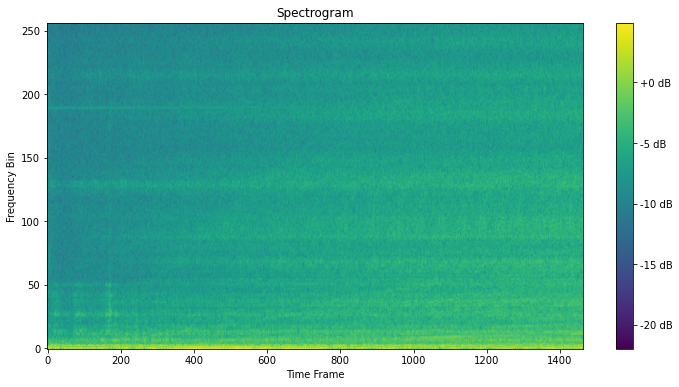

In [61]:
# 복소수의 크기를 계산하여 시각화에 사용
# magnitude = torch.abs(stft_result)

# 시각화를 위한 코드
plt.figure(figsize=(12, 6))
plt.imshow(magnitude.log2().numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.show()

In [16]:
# from scipy.io.wavfile import write

# def txt_to_wav(input_file_path, output_wav_path, sampling_rate=12800):
#     # Read the data from the text file
#     with open(input_file_path, 'r') as file:
#         lines = file.readlines()
    
#     samples = []
#     for line in lines:
#         _, sample = line.split("\t")
#         samples.append(float(sample))
    
#     # Convert list to numpy array
#     samples_array = np.array(samples, dtype=np.float32)

#     # Save to WAV file
#     write(output_wav_path, sampling_rate, samples_array)

# # Example usage of the function
# input_file = 'path/to/your/input.txt'  # Adjust this to your text file path
# output_file = 'output_audio.wav'
# txt_to_wav(input_file, output_file)